# LEXICON HDC METHOD

In [1]:
# Import Basic Packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import copy
import nltk
import string
import random
import time
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from nltk import sent_tokenize,word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import *
from tabulate import tabulate
from os import listdir
from pandas import *

## Data Insights and Pre-Processing

In [2]:
### Function: Collects sample data from files in Stanford Dataset Subfolders
    ## Inputs: folderpath: Path to Desired Folder
    ##         sentiment:  Sentiment Value (0 or 1)
    ## Output: df: Pandas Dataframe of all Sample Data found in desired folder
def stanfordDatasetFolderDataLoader(folderpath, sentiment):
    file_list=listdir(folderpath)

    df = pd.DataFrame(columns = ['Review', 'Sentiment'])
    for file in file_list:
        filepath=folderpath + file
        f = open(filepath,'r', encoding="utf-8")
        sample = f.read()
        f.close()
        df = df.append({'Review' : sample, 'Sentiment' : sentiment}, ignore_index = True)
    return df

# Choose Dataset (0: Sentiment140, 1: Stanford IMBD Dataset)
dataset = 0

# Load Dataset
if (dataset==0):
    print('Using Sentiment140 Twitter Dataset...')
    # Read in Sentiment140 data from CSV
    df = pd.read_csv('./Sentiment140_Tweets/data.csv')
    df.columns =['Sentiment', 'IDs', 'Date', 'Flag', 'User', 'Tweet']
else:
    print('Using Stanford IMBD Movie Review Dataset...')
    # Read in Training Stanford IMBD Movie Review data from subfolders
    train_pos=stanfordDatasetFolderDataLoader('./StanfordMovie/train/pos/',1)
    train_neg=stanfordDatasetFolderDataLoader('./StanfordMovie/train/neg/',0)
    train_df=pd.concat([train_pos, train_neg], axis=0)
    
    # Read in Testing Stanford IMBD Movie Review data from subfolders
    test_pos=stanfordDatasetFolderDataLoader('./StanfordMovie/test/pos/',1)
    test_neg=stanfordDatasetFolderDataLoader('./StanfordMovie/test/neg/',0)
    test_df=pd.concat([test_pos, test_neg], axis=0)

    df=pd.concat([train_df, test_df], axis=0)
print('Total number of Samples In Dataset:', len(df))

Using Sentiment140 Twitter Dataset...
Total number of Samples In Dataset: 1599999


In [3]:
# Dataset Cleanup:

# Sentiment140 Sentiment Clean Up
if dataset==0:
    # Replace Sentiment of 4 (Positive) with 1
    df["Sentiment"].replace({4: 1}, inplace=True)
    # Eliminate Neutral Tweets, if any
    df = df[df['Sentiment'] != 2]

# Check for Null Values
if ( not df.isnull().values.any() ):
    print("Dataset in Use has No NULL values.")
else:
    df.dropna(inplace=True)

print("Dataset Length after Cleanup:", len(df))

Dataset in Use has No NULL values.
Dataset Length after Cleanup: 1599999


In [4]:
# Downsample the Dataset to 5,000 Total Samples
if (dataset==0):
    percentage = 0.003125
else:
    percentage = 0.1
df_downsampled = df.sample(frac=percentage,random_state=0)
df_downsampled

,Sentiment,IDs,Date,Flag,User,Tweet
1016244,1,1881672289,Fri May 22 05:16:44 PDT 2009,NO_QUERY,viry_trivium,"Happy birthday, sister!"
1303317,1,2009051656,Tue Jun 02 15:04:22 PDT 2009,NO_QUERY,Earlthedog,Just finished eating supper and now I am attac...
576684,0,2211886069,Wed Jun 17 13:24:27 PDT 2009,NO_QUERY,StefyyMarie,i hate love right now.
837327,1,1558734942,Sun Apr 19 09:15:07 PDT 2009,NO_QUERY,tezzer57,"Photo fest in LDN, Tudor feast last night, don..."
985344,1,1834470136,Mon May 18 03:03:30 PDT 2009,NO_QUERY,dave_sherratt,"@piercedbrat happy bday for tomoz, all the bes..."
...,...,...,...,...,...,...
1369789,1,2050886442,Fri Jun 05 19:28:18 PDT 2009,NO_QUERY,thaisprudencio,today was awesome!
587089,0,2216194514,Wed Jun 17 19:09:39 PDT 2009,NO_QUERY,alwyshoutashley,I wish it would stop raining. I'm ready for th...
46597,0,1677444411,Sat May 02 02:06:29 PDT 2009,NO_QUERY,kasey79,@DannyGirlAlways Ok I still feel kind of bad t...
1409132,1,2055829198,Sat Jun 06 10:01:49 PDT 2009,NO_QUERY,Bockman13,Hanging with Anna and Fernando!


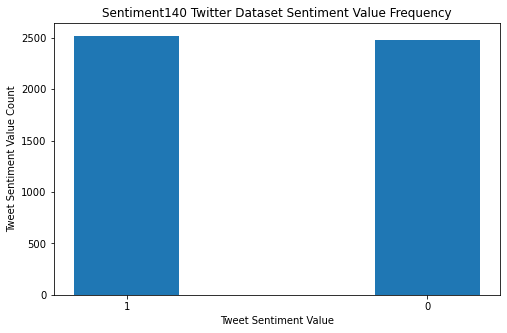

Where Sentiment is Positive when Sentiment Value = 1 and Negative when Sentiment Value = 0


In [5]:
# Visualization of Dataset Sentiment Outcomes - Ensured Even Distribution of Outcomes
sent_count = df_downsampled['Sentiment'].value_counts()
plt.figure(figsize=(8, 5))
w = 0.35  
plt.bar(x=np.arange(len(sent_count)), height=sent_count, width = w)
plt.xticks(np.arange(len(sent_count)), sent_count.index.tolist())

if dataset==0:
    plt.xlabel('Tweet Sentiment Value')
    plt.ylabel('Tweet Sentiment Value Count')
    plt.title('Sentiment140 Twitter Dataset Sentiment Value Frequency')
else:
    plt.xlabel('Movie Review Sentiment Value')
    plt.ylabel('Movie Review Sentiment Value Count')
    plt.title('Stanford IMBD Movie Review Dataset Sentiment Value Frequency')
plt.show()
print('Where Sentiment is Positive when Sentiment Value = 1 and Negative when Sentiment Value = 0')

In [6]:
### Function: Pre-Processes Samples
    ## Inputs: samples:        Array of samples
    ##         sample_results: Sentiment of Input Samples
    ## Outputs: pre_procc_samps: Array of samples pre-processed
    ##          pre_procc_res:   Array of results for pre-processed samples      
def PreProcess(samples, sample_results):
    pre_procc_samps = []
    pre_procc_res=[]

    # Storing all punctuations using RE library like !;,"% etc
    re_puncs = re.compile('[%s]' % re.escape(string.punctuation))
    # Lemmatizing object
    lem = WordNetLemmatizer()

    index=0
    for sample in samples:
        
        # Replace Repeated Characters with 2 instance and get rid or URLs / Handles
        sample=re.sub(r"(\w)\1{2,}", r"\1\1", str(sample))
        sample = re.sub(r"http\S+", "", str(sample))
        sample = re.sub(r"@\S+", "", str(sample))

        # Get words in sample
        words = word_tokenize(str(sample))

        # Converting all characters to lower case
        words_lower = [w.lower() for w in words]              

        # Remove all punctuation
        words_lower_no_punc = [re_puncs.sub('', w) for w in words_lower]

        # Keep only alpha words
        words_lower_alpha = [i for i in words_lower_no_punc if i.isalpha()]

        # POS Tagging
        pos_tagged_words = nltk.pos_tag(words_lower_alpha)
        filtered_pos = [t[0] for t in pos_tagged_words if t[1] == "NN" or t[1] == "NNS" or t[1].startswith('J') or t[1].startswith('RB') or t[1].startswith('V') or t[1] == "UH" or t[1] == "WRB" or t[1] == "POS"]

        # Doing Lemmatizing of words
        words_lower_alpha_pos_lemma = [lem.lemmatize(w) for w in filtered_pos]

        # Convert back to string and (possibly) one-hot encode tweet
        pre_procc_str = ' '.join(words_lower_alpha_pos_lemma)
        if (pre_procc_str != ""):
            pre_procc_samps.append(pre_procc_str)
            pre_procc_res.append(sample_results[index])
        index=index+1
        
    return pre_procc_samps, pre_procc_res

# Pre-Proccess the Dataset
if dataset==0:
    Xdf, Ydf = PreProcess(df_downsampled['Tweet'].to_numpy(), df_downsampled['Sentiment'].to_numpy())
else:
    Xdf, Ydf = PreProcess(df_downsampled['Review'].to_numpy(), df_downsampled['Sentiment'].to_numpy())

# Get Final Train/Test Sets:
TrainXdf,TestXdf, TrainYdf, TestYdf = train_test_split(Xdf, Ydf,test_size=.2, random_state=2)
TrainYdf=np.array(TrainYdf)
TestYdf=np.array(TestYdf)
TrainXdf[1:5]

['beach haha gon miss weekend hopefully something happen again update soon beach i',
 'reason i miss nephew lot today sigh',
 'i only know bubble co rock i only assume mean i wa bubble',
 'i clearly need try bath part i mean too bad i wa nt bootcamp']

## Pre-Training Initialization
### Generate Lexicons

In [7]:
### Function: Automatic Unigram and Bigram Lexicon Generation
    ## Inputs: TrainXdf: Training Samples
    ##         TrainYdf: Training Sample Results
    ## Outputs: unigram_lexicon: Unigram Lexicon generated from Labelled Training Data
    ##          bigram_lexicon:  Bigram Lexicon generated from Labelled Training Data
def buildLexicons(TrainXdf,TrainYdf):
    
    # Initialization
    unigram_pos_count_dict={}
    unigram_neg_count_dict={}
    unigram_lexicon={}

    bigram_pos_count_dict={}
    bigram_neg_count_dict={}
    bigram_lexicon={}
    
    index=0

    for tweet in TrainXdf:

        # Get words in tweet
        words = word_tokenize(str(tweet))

        # Initialization
        next_word_idx = 1
        prev_unigrams=[]
        prev_bigrams=[]

        for word in words:
    
            # Unigram lexicon:
            # Increment Positive Count
            if TrainYdf[index]==1 and word not in prev_unigrams:
                if word in unigram_pos_count_dict:
                    unigram_pos_count_dict[word]=unigram_pos_count_dict[word]+1
                else:
                    unigram_pos_count_dict[word]=1
                    unigram_neg_count_dict[word]=0
                prev_unigrams.append(word)
            # Increment Negative Count
            elif TrainYdf[index]==0 and word not in prev_unigrams:
                if word in unigram_neg_count_dict:
                    unigram_neg_count_dict[word]=unigram_neg_count_dict[word]+1
                else:
                    unigram_neg_count_dict[word]=1
                    unigram_pos_count_dict[word]=0
                prev_unigrams.append(word)

            # Bigram lexicon:
            if (next_word_idx < len(words)):
                bigram = word + " " + words[next_word_idx]
                next_word_idx = next_word_idx + 1

                # Increment Positive Count
                if TrainYdf[index]==1 and bigram not in prev_bigrams:
                    if bigram in bigram_pos_count_dict:
                        bigram_pos_count_dict[bigram]=bigram_pos_count_dict[bigram]+1
                    else:
                        bigram_pos_count_dict[bigram]=1
                        bigram_neg_count_dict[bigram]=0
                    prev_bigrams.append(bigram)
                # Increment Negative Count
                elif TrainYdf[index]==0 and bigram not in prev_bigrams:
                    if bigram in bigram_neg_count_dict:
                        bigram_neg_count_dict[bigram]=bigram_neg_count_dict[bigram]+1
                    else:
                        bigram_neg_count_dict[bigram]=1
                        bigram_pos_count_dict[bigram]=0
                    prev_bigrams.append(bigram)

        index=index+1
    
    # Calculate polarity score for each word and add pair to the unigram lexicon
    for key in unigram_pos_count_dict.keys():
        if ((unigram_pos_count_dict[key]+unigram_neg_count_dict[key]) >= .01*len(TrainYdf)):
            pos_sent_score = unigram_pos_count_dict[key]/(unigram_pos_count_dict[key]+unigram_neg_count_dict[key])
            if (pos_sent_score < 0.4 or pos_sent_score > 0.6):
                polarity_score = 2*pos_sent_score-1
                unigram_lexicon[key]=polarity_score

    # Calculate polarity score for each word and add pair to the bigram lexicon
    for key in bigram_pos_count_dict.keys():
        if ((bigram_pos_count_dict[key]+bigram_neg_count_dict[key]) >= .01*len(TrainYdf)):
            pos_sent_score = bigram_pos_count_dict[key]/(bigram_pos_count_dict[key]+bigram_neg_count_dict[key])
            if (pos_sent_score < 0.4 or pos_sent_score > 0.6):
                polarity_score = 2*pos_sent_score-1
                bigram_lexicon[key]=polarity_score

    return unigram_lexicon, bigram_lexicon

# Automatic Unigram and Bigram Lexicon Generation
auto_unigram_lexicon, auto_bigram_lexicon = buildLexicons(TrainXdf,TrainYdf)

# Get WKWSCI Lexicon
xls = ExcelFile('WKWSCISentimentLexicon_v1.1.xlsx')
data = xls.parse(xls.sheet_names[3])
WKWSCI_lexicon = data.set_index("term")["sentiment"].to_dict()

### Lexicon Value List Function

In [8]:
### Function: Get list of possible lexicon values
    ## Inputs: totalLexLevels: Total Number of Lexicon Score Values
    ##         minLexVal:      Smallest Lexicon Score Value 
    ##         maxLexVal:      Largest Lexicon Score Value 
    ## Output: lexiconValueList: List of All possible Lexicon Values
def getLexiconValueList(totalLexLevels, minLexVal, maxLexVal):
    lexiconValueList = []
    length = maxLexVal - minLexVal
    gap = length / totalLexLevels

    for val in range(totalLexLevels):
        lexiconValueList.append(minLexVal + val*gap)

    lexiconValueList.append(maxLexVal)
    return lexiconValueList

# Parameters:
HV_dim = 10000
minLexVal = -1
maxLexVal = 1

### Item Memory Function

In [9]:
### Function: Item Memory Generation
    ## Inputs: totalLexLevels: Total Number of Lexicon Score Values
    ##         minLexVal:      Smallest Lexicon Score Value 
    ##         HV_dim:         Dimension of HV
    ## Output: itemMem: Item Memory containing HVs for each Possible Lexicon Score Value
def itemMemGen(totalLexLevels, minLexVal, HV_dim):
    itemMem = dict()
    indexVector = range(HV_dim)
    nextLevel = int((HV_dim/2/totalLexLevels))
    change = int(HV_dim/2)
    for level in range(totalLexLevels):
        name = level
        if(level == 0):
            base = np.full(HV_dim, minLexVal)
            toOne = np.random.permutation(indexVector)[:change]
        else:
            toOne = np.random.permutation(indexVector)[:nextLevel]
        for index in toOne:
            base[index] = base[index] * -1
        itemMem[name] = copy.copy(base)
    return itemMem

### Training Functions

In [10]:
### Function: Binary search for Value in Lexicon Value List
    ## Inputs: value:            Value Trying to Find in List
    ##         lexiconValueList: List of Possible Lexicon Values
    ## Output: ValueIndex: Index of Desired Value in Lexicon Value List
def numToValueIndex(value, lexiconValueList):
    if (value == lexiconValueList[-1]):
        return len(lexiconValueList)-2
    upperIndex = len(lexiconValueList) - 1
    lowerIndex = 0
    ValueIndex = 0
    while (upperIndex > lowerIndex):
        ValueIndex = int((upperIndex + lowerIndex)/2)
        if (lexiconValueList[ValueIndex] <= value and lexiconValueList[ValueIndex+1] > value):
            return ValueIndex
        if (lexiconValueList[ValueIndex] > value):
            upperIndex = ValueIndex
            ValueIndex = int((upperIndex + lowerIndex)/2)
        else:
            lowerIndex = ValueIndex
            ValueIndex = int((upperIndex + lowerIndex)/2)
    return ValueIndex

### Function: Normalizes WKWSCI Sentiment Score in the Range [-1, 1]
    ## Input: value: WKWSCI value
    ## Output: norm_val: Normalized WKWSCI value
def normWKWSCI(value):
    WKWSCI_max = 3
    WKWSCI_min = -3
    norm_val = 2 * ((value-WKWSCI_min)/(WKWSCI_max-WKWSCI_min))- 1
    return norm_val

### Function: Encodes a Sample into a HV using LEXICON HDC Approach
    ## Inputs: sample:               Training Sample
    ##         itemMem:              Generated Item Memory
    ##         lexiconValueList:     List of Possible Lexicon Values 
    ##         encode_method:        Encode Method (0 - ADD, 1 - MULT)
    ##         lex_type_flag:        Type of Lexicon Using (0 - UNIGRAM, 1 - BIGRAM)
    ##         combo_flag:           Lexicon(s) Using (0 - WKWSCI, 1 - EITHER WKWSCI+AUTO or AUTO [DEPENDS ON LEX_TYPE] )
    ##         WKWSCI_lexicon:       WKWSCI Lexicon
    ##         auto_unigram_lexicon: Automatic Unigram Lexicon Generated
    ##         auto_bigram_lexicon:  Automatic Bigram Lexicon Generated
    ## Output: sample_HV: HV of inputted sample 
def encode(sample, itemMem, lexiconValueList, encode_method, lex_type_flag, combo_flag, WKWSCI_lexicon, auto_unigram_lexicon, auto_bigram_lexicon):
    sample_HV = np.zeros(HV_dim, dtype='int32')
    sample = word_tokenize(sample)
    
    next_word_idx=1
    first=1

    for word in sample:
        if combo_flag==1:
            if lex_type_flag==0:
                if word in WKWSCI_lexicon:
                    raw_lexicon_score = WKWSCI_lexicon[word]
                    lexicon_score = normWKWSCI(raw_lexicon_score)
                    if word in auto_unigram_lexicon:
                        other_score = auto_unigram_lexicon[word]
                        lexicon_score=0.5*(lexicon_score + other_score)
                elif word in auto_unigram_lexicon:
                    lexicon_score = auto_unigram_lexicon[word]
                else:
                    continue
            elif next_word_idx < len(sample):
                bigram = word + " " + sample[next_word_idx]
                next_word_idx=next_word_idx+1
                if bigram in auto_bigram_lexicon:
                    lexicon_score = auto_bigram_lexicon[bigram]
                else:
                    continue
            else:
                continue
        elif combo_flag==0 and lex_type_flag==0:
            if word in WKWSCI_lexicon:
                raw_lexicon_score = WKWSCI_lexicon[word]
                lexicon_score = normWKWSCI(raw_lexicon_score)
            else:
                continue

        HV_score_index = numToValueIndex(lexicon_score, lexiconValueList)

        if encode_method==0:   
            if first==1:
                sample_HV = itemMem[HV_score_index]
                first=0
            else:
                sample_HV=sample_HV*itemMem[HV_score_index]
        else:
            sample_HV=sample_HV+itemMem[HV_score_index]
    
    sample_HV=sample_HV.flatten()

    return sample_HV


### Function: LEXICON HDC Training Function that creates an Associative Memory for the Model
    ## Inputs: X:                    Training Samples
    ##         Y:                    Outputs of Training Samples
    ##         itemMem:              Generated Item Memory
    ##         HV_dim:               Dimension of HV
    ##         sent_count:           Number of Possible Sentiment Values
    ##         lexiconValueList:     List of Possible Lexicon Values 
    ##         encode_method:        Encode Method (0 - ADD, 1 - MULT)
    ##         lex_type_flag:        Type of Lexicon Using (0 - UNIGRAM, 1 - BIGRAM)
    ##         combo_flag:           Lexicon(s) Using (0 - WKWSCI, 1 - EITHER WKWSCI+AUTO or AUTO [DEPENDS ON LEX_TYPE] )
    ##         WKWSCI_lexicon:       WKWSCI Lexicon
    ##         auto_unigram_lexicon: Automatic Unigram Lexicon Generated
    ##         auto_bigram_lexicon:  Automatic Bigram Lexicon Generated
    ## Output: assocMem: Associative Memory 
def train(X, Y, itemMem, HV_dim, sent_count, lexiconValueList, encode_method, lex_type_flag, combo_flag, WKWSCI_lexicon, auto_unigram_lexicon, auto_bigram_lexicon):
    assocMem = np.zeros((sent_count, HV_dim), dtype='int32')
    sample_idx = 0
    
    for sample in X:
        sample_HV = encode(sample, itemMem, lexiconValueList, encode_method, lex_type_flag, combo_flag, WKWSCI_lexicon, auto_unigram_lexicon, auto_bigram_lexicon)
        assocMem[Y[sample_idx]] = np.add(assocMem[Y[sample_idx]], sample_HV)
        sample_idx += 1
    
    return assocMem

### Testing Functions

In [11]:
### Function: Compares Input HV to Class HVs and Returns the Predicted Class
    ## Inputs: assocMem: Model's Associative Memory
    ##         inputHV:  Encoded HV of a sample
    ## Output: pred: the predicted class
def get_prediction(assocMem, inputHV):
    pred = assocMem[0]
    maximum = np.NINF

    for index in range(len(assocMem)):
        similarity = cosine_similarity([inputHV, assocMem[index]])[0][1]  
        if (similarity > maximum):
            pred = index
            maximum = similarity

    return pred

### Function: Tests the LEXICON HDC Model and Returns Accuracy of Model
    ## Inputs: itemMem:          Generated Item Memory
    ##         assocMem:         Model's Associative Memory
    ##         TestXdf:          Test Samples
    ##         TextYdf:          Sentiment of Test Samples
    ##         lexiconValueList: List of Possible Lexicon Values 
    ##         encode_method:    Encode Method (0 - ADD, 1 - MULT)
    ##         lex_type_flag:        Type of Lexicon Using (0 - UNIGRAM, 1 - BIGRAM)
    ##         combo_flag:           Lexicon(s) Using (0 - WKWSCI, 1 - EITHER WKWSCI+AUTO or AUTO [DEPENDS ON LEX_TYPE] )
    ##         WKWSCI_lexicon:   WKWSCI Lexicon
    ##         auto_unigram_lexicon: Automatic Unigram Lexicon Generated
    ##         auto_bigram_lexicon:  Automatic Bigram Lexicon Generated
    ## Output: accuracy: Accuracy of the Model
def test(itemMem, assocMem, TestXdf, TestYdf, lexiconValueList, encode_method, lex_type_flag, combo_flag, WKWSCI_lexicon, auto_unigram_lexicon, auto_bigram_lexicon):
    true_pos_count=0
    false_pos_count=0
    correct_count = 0

    for index in range(len(TestXdf)):
        prediction = get_prediction(assocMem, encode(TestXdf[index], itemMem, lexiconValueList, encode_method, lex_type_flag, combo_flag, WKWSCI_lexicon, auto_unigram_lexicon, auto_bigram_lexicon))
        if (TestYdf[index] == prediction):
            correct_count += 1
            if prediction==1:
                true_pos_count = true_pos_count + 1
        elif prediction==1:
            false_pos_count = false_pos_count + 1
    
    accuracy = (correct_count / len(TestYdf)) * 100
    if (true_pos_count+false_pos_count) != 0:
        precision = (true_pos_count/ (true_pos_count+false_pos_count)) * 100
    else:
        precision=0
    return accuracy, precision

## Optimal Hyperparameter Search
### One-Shot Training/Accuracy of Various Sets of Hyperparameter Values

In [12]:
# Hyperparameters
lex_combos = [0, 1] # 0 for WKWSCI, 1 for WKWSCI+AUTO
auto_lexicon_type = [0, 1] # 0 for UNIGRAM, 1 for BIGRAM
num_lex_values = [75, 100, 150]
encode_method = [0, 1] # 0 for MULT, 1 for ADD 

# Optimal Result Initialization
best_acc=0
lex_combos_best=0
auto_lexicon_type_best=0
num_lex_values_best=0
encode_method_best=0
output_best_lex_used=""
output_best_lex_type=""
lexiconValueList_best=[]
best_assocMem=[]
itemMem_best=[]

# Generate Item Memories and Lexicon Value Lists Once for Each Option of Number of Lexicon Values
ItemMem_75, ItemMem_100, ItemMem_150=[], [], []
LexValueList_75, LexValueList_100, LexValueList_150=[], [], []
for num_lex in num_lex_values:
    if num_lex==75:
        ItemMem_75 = itemMemGen(num_lex, minLexVal, HV_dim)
        LexValueList_75 = getLexiconValueList(num_lex, minLexVal, maxLexVal)
    elif num_lex==100:
        ItemMem_100 = itemMemGen(num_lex, minLexVal, HV_dim)
        LexValueList_100 = getLexiconValueList(num_lex, minLexVal, maxLexVal)
    elif num_lex==150:
        ItemMem_150 = itemMemGen(num_lex, minLexVal, HV_dim)
        LexValueList_150 = getLexiconValueList(num_lex, minLexVal, maxLexVal)

# Generate Table Initialization
table_data=[]
col_names = ["LEXICON(S) USED", "TYPE OF LEXICON(S)", "NUMBER OF LEXICON VALUES", "ENCODE METHOD", "ONE-SHOT ACCURACY", "ONE-SHOT-PRECISION", "TRAINING TIME (s)", "NUMBER OF TRAINING SAMPLES", "TESTING TIME (s)", "NUMBER OF TESTING SAMPLES"]

for auto_lex_type in auto_lexicon_type:
    for combo in lex_combos:            
        if auto_lex_type==1 and combo==0:
            continue

        for num_lex in num_lex_values:
            # Set ItemMem and Lexicon Value List
            if num_lex==75:
                itemMem = copy.copy(ItemMem_75)
                lexiconValueList = copy.copy(LexValueList_75)
            elif num_lex==100:
                itemMem = copy.copy(ItemMem_100)
                lexiconValueList = copy.copy(LexValueList_100)
            elif num_lex==150:
                itemMem = copy.copy(ItemMem_150)
                lexiconValueList = copy.copy(LexValueList_150)

            for method in encode_method:

                # Train Model (i.e. Generate Model's Associative Memory)
                t0=time.time()
                assocMem = train(TrainXdf, TrainYdf, itemMem, HV_dim, len(sent_count), lexiconValueList, method, auto_lex_type, combo, WKWSCI_lexicon, auto_unigram_lexicon, auto_bigram_lexicon)
                t1=time.time()
                train_time = t1-t0

                # One-Shot Training Results
                t0=time.time()
                one_shot_accuracy, one_shot_precision =test(itemMem, assocMem, TestXdf, TestYdf, lexiconValueList, method, auto_lex_type, combo, WKWSCI_lexicon, auto_unigram_lexicon, auto_bigram_lexicon)
                t1=time.time()
                test_time = t1-t0

                if combo==1:
                    if auto_lex_type==0:
                        # Collect Data for Table
                        data = ["WKWSCI + AUTOMATIC", "UNIGRAM", num_lex, method, one_shot_accuracy, one_shot_precision, train_time, len(TrainYdf), test_time, len(TestYdf)]
                        lex_used="WKWSCI + AUTOMATIC"
                        lex_type="UNIGRAM"
                    else:
                        # Collect Data for Table
                        data = ["AUTOMATIC", "BIGRAM", num_lex, method, one_shot_accuracy, one_shot_precision, train_time, len(TrainYdf), test_time, len(TestYdf)]
                        lex_used="AUTOMATIC"
                        lex_type="BIGRAM"
                elif combo==0:
                    # Collect Data for Table
                    data = ["WKWSCI", "UNIGRAM", num_lex, method, one_shot_accuracy, one_shot_precision, train_time, len(TrainYdf), test_time, len(TestYdf)]
                    lex_used="WKWSCI"
                    lex_type="UNIGRAM"

                # Add Data to Table
                table_data.append(data)

                if one_shot_accuracy>best_acc:
                    best_acc=one_shot_accuracy
                    best_assocMem=copy.copy(assocMem)
                    itemMem_best=copy.copy(itemMem)
                    lexiconValueList_best=copy.copy(lexiconValueList)
                    
                    lex_combos_best=combo
                    auto_lexicon_type_best=auto_lex_type
                    num_lex_values_best=num_lex
                    encode_method_best=method

                    output_best_lex_used=lex_used
                    output_best_lex_type=lex_type

# Get Necessary Components for Best Model
assocMem=copy.copy(best_assocMem)
itemMem=copy.copy(itemMem_best)
lexiconValueList=copy.copy(lexiconValueList_best)
encode_method=encode_method_best
lexicon_type=auto_lexicon_type_best
combo=lex_combos_best

# Save Results to File
df=pd.DataFrame(table_data, columns=col_names)
filepath="./Results/HyperparameterResults/LEXICON_" + str(dataset) +".csv"
df.to_csv(filepath)
            
print("Results of Various Hyperparameter Sets:")
print(tabulate(table_data, headers=col_names, tablefmt="simple"))
print("\nEncode Method Key: 0 for MULT, 1 for ADD\n")
print("Best Hyperparameters: LEXICON(S) USED: ", output_best_lex_used, ", TYPE OF LEXICON(S): ", output_best_lex_type, ", NUMBER OF LEXICON VALUES: ", num_lex_values_best, ", ENCODE METHOD: ", encode_method_best)
print("Best One-Shot Accuracy: ", best_acc)

Results of Various Hyperparameter Sets:
LEXICON(S) USED     TYPE OF LEXICON(S)      NUMBER OF LEXICON VALUES    ENCODE METHOD    ONE-SHOT ACCURACY    ONE-SHOT-PRECISION    TRAINING TIME (s)    NUMBER OF TRAINING SAMPLES    TESTING TIME (s)    NUMBER OF TESTING SAMPLES
------------------  --------------------  --------------------------  ---------------  -------------------  --------------------  -------------------  ----------------------------  ------------------  ---------------------------
WKWSCI              UNIGRAM                                       75                0              57.0712               59.7015             1.06412                           3988            1.6466                            997
WKWSCI              UNIGRAM                                       75                1              62.989                68.0288             1.86901                           3988            1.54309                           997
WKWSCI              UNIGRAM                 

## Retraining Optimal Model

In [13]:
### Function: VECTORIZED HDC Re-Training Function that creates a New Associative Memory for the Model
    ## Inputs: X:                    Training Samples
    ##         Y:                    Outputs of Training Samples
    ##         itemMem:              Generated Item Memory
    ##         assocMem:             Associative Memory of Current Model
    ##         lexiconValueList:     List of Possible Lexicon Values 
    ##         encode_method:        Encode Method (0 - ADD, 1 - MULT)
    ##         lex_type_flag:        Type of Lexicon Using (0 - UNIGRAM, 1 - BIGRAM)
    ##         combo_flag:           Lexicon(s) Using (0 - WKWSCI, 1 - EITHER WKWSCI+AUTO or AUTO [DEPENDS ON LEX_TYPE] )
    ##         WKWSCI_lexicon:       WKWSCI Lexicon
    ##         auto_unigram_lexicon: Automatic Unigram Lexicon Generated
    ##         auto_bigram_lexicon:  Automatic Bigram Lexicon Generated
    ##         alpha:                Learning Rate Parameter
    ## Output: assocMem: New Associative Memory
def retrain(X, Y, itemMem, assocMem, lexiconValueList, encode_method, lex_type_flag, combo_flag, WKWSCI_lexicon, auto_unigram_lexicon, auto_bigram_lexicon, alpha):
    sample_index = 0
    for sample in X:
        sample_HV = encode(sample, itemMem, lexiconValueList, encode_method, lex_type_flag, combo_flag, WKWSCI_lexicon, auto_unigram_lexicon, auto_bigram_lexicon)
        prediction = get_prediction(assocMem, sample_HV)
        if prediction != Y[sample_index]:
            assocMem[Y[sample_index]] = np.add(assocMem[Y[sample_index]], alpha * sample_HV)
            assocMem[prediction] = np.subtract(assocMem[prediction], alpha * sample_HV)
        sample_index += 1
    return assocMem

# Re-Train Optimal Model with Learning Parameter
learningparam_results=[]
num_epochs = 20
print('-------- Retraining Model w Learning Parameter: ', num_epochs, ' Epochs --------')
for epoch in range(num_epochs):
    assocMem = retrain(TrainXdf, TrainYdf, itemMem, assocMem, lexiconValueList, encode_method, lexicon_type, combo, WKWSCI_lexicon, auto_unigram_lexicon, auto_bigram_lexicon, alpha = num_epochs - epoch)
    acc, prec = test(itemMem, assocMem, TestXdf, TestYdf, lexiconValueList, encode_method, lexicon_type, combo, WKWSCI_lexicon, auto_unigram_lexicon, auto_bigram_lexicon)
    print('Epoch ', (epoch+1), ': ', acc)
    learningparam_results.append([acc,prec])

# Re-Train Optimal Model without Learning Parameter
assocMem=copy.copy(best_assocMem)
no_learningparam_results=[]
print('-------- Retraining Model without Learning Parameter: ', num_epochs, ' Epochs --------')
for epoch in range(num_epochs):
    assocMem = retrain(TrainXdf, TrainYdf, itemMem, assocMem, lexiconValueList, encode_method, lexicon_type, combo, WKWSCI_lexicon, auto_unigram_lexicon, auto_bigram_lexicon, alpha = 1)
    acc, prec = test(itemMem, assocMem, TestXdf, TestYdf, lexiconValueList, encode_method, lexicon_type, combo, WKWSCI_lexicon, auto_unigram_lexicon, auto_bigram_lexicon)
    print('Epoch ', (epoch+1), ': ', acc)
    no_learningparam_results.append([acc,prec])

# Save All Results to Files
col_name=["Accuracy", "Precision"]

df_lp=pd.DataFrame(learningparam_results, columns=col_name)
filepath="./Results/EpochResults_LearningParam/LEXICON_" + str(dataset) + ".csv"
df_lp.to_csv(filepath)

df_nlp=pd.DataFrame(no_learningparam_results, columns=col_name)
filepath="./Results/EpochResults_NoLearningParam/LEXICON_" + str(dataset) + ".csv"
df_nlp.to_csv(filepath)

-------- Retraining Model w Learning Parameter:  20  Epochs --------
Epoch  1 :  66.29889669007021
Epoch  2 :  68.00401203610834
Epoch  3 :  68.90672016048146
Epoch  4 :  68.7061183550652
Epoch  5 :  65.79739217652958
Epoch  6 :  65.89769307923771
Epoch  7 :  68.3049147442327
Epoch  8 :  68.40521564694082
Epoch  9 :  68.00401203610834
Epoch  10 :  67.80341023069208
Epoch  11 :  68.90672016048146
Epoch  12 :  68.40521564694082
Epoch  13 :  68.10431293881645
Epoch  14 :  68.00401203610834
Epoch  15 :  69.00702106318957
Epoch  16 :  67.90371113340021
Epoch  17 :  69.30792377131394
Epoch  18 :  67.70310932798395
Epoch  19 :  68.80641925777333
Epoch  20 :  68.3049147442327
-------- Retraining Model without Learning Parameter:  20  Epochs --------
Epoch  1 :  67.70310932798395
Epoch  2 :  67.10130391173522
Epoch  3 :  67.70310932798395
Epoch  4 :  68.10431293881645
Epoch  5 :  69.30792377131394
Epoch  6 :  68.3049147442327
Epoch  7 :  67.70310932798395
Epoch  8 :  66.90070210631896
Epoch  9 